In [1]:
#!pip install pyreadr

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as snc
import pyreadr
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline

__Reading the FaultyFree training and Faulty training data__

In [3]:
result_train = pyreadr.read_r('../../data/TEP_FaultFree_Training.RData')
key_train=result_train.keys()
print(key_train)

odict_keys(['fault_free_training'])


In [4]:
result_faulty = pyreadr.read_r('../../data/TEP_Faulty_Training.RData')
key_faulty=result_faulty.keys()
print(key_faulty)

odict_keys(['faulty_training'])


In [5]:
df_train = result_train['fault_free_training']
df_faulty = result_faulty['faulty_training']

In [6]:
df_concat=pd.concat([df_train,df_faulty])

We filter just for failure case 1

In [7]:
DF=df_concat[(df_concat['simulationRun']==1) & (df_concat['faultNumber']==0)] 
DF_faulty=df_concat[(df_concat['simulationRun']==1) & (df_concat['faultNumber']==4)] 

In [8]:
df_train_clean=DF.drop(['sample','simulationRun','faultNumber'], axis=1)
df_faulty_clean=DF_faulty.drop(['sample','simulationRun','faultNumber'], axis=1)

We check the dimensionality of the data

In [9]:
df_train_clean.shape,df_faulty_clean.shape

((500, 52), (500, 52))

__Scaling data and check pca principal components__

In [10]:
scaler = StandardScaler()
df_train_scaled=scaler.fit_transform(df_train_clean)

In [11]:
pca=PCA()
X_pca=pca.fit_transform(df_train_scaled)

var_pca=pca.explained_variance_ratio_

cum_sum_eig=np.cumsum(var_pca)

In this case a variance of 0.9 has been chosen. We plot the principal components variance, the cumulative variance and the variance threshold chosen 0.9

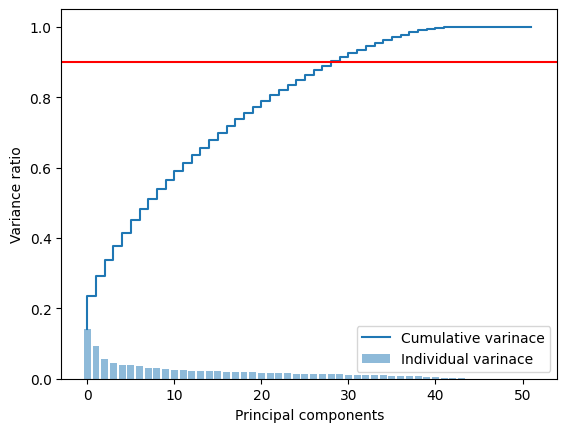

In [12]:
plt.bar(range(0,len(var_pca)),var_pca,label='Individual varinace', alpha=0.5)
plt.step(range(0,len(cum_sum_eig)),cum_sum_eig,label='Cumulative varinace')
plt.axhline(y=0.9, color='r', linestyle='-')
plt.xlabel('Principal components')
plt.ylabel('Variance ratio')
plt.legend()
plt.show()

__PCA__

__Free Faulty case - Training of the model__

In [41]:
pca = PCA(n_components=0.90) #90% variance of the data is captured
principalComponents = pca.fit_transform(df_train_scaled)
principalDf = pd.DataFrame(data = principalComponents)
np.sum(pca.explained_variance_ratio_)

0.9016855259039157

In [42]:
columns=df_train_clean.columns.to_list()

In [43]:
FreeFaulty_reconstructed= pca.inverse_transform(principalDf)
FreeFaulty_inverse=scaler.inverse_transform(FreeFaulty_reconstructed)
FreeFaulty_restored_plot = pd.DataFrame(FreeFaulty_inverse, index=principalDf.index)
FreeFaulty_restored_plot.columns = columns

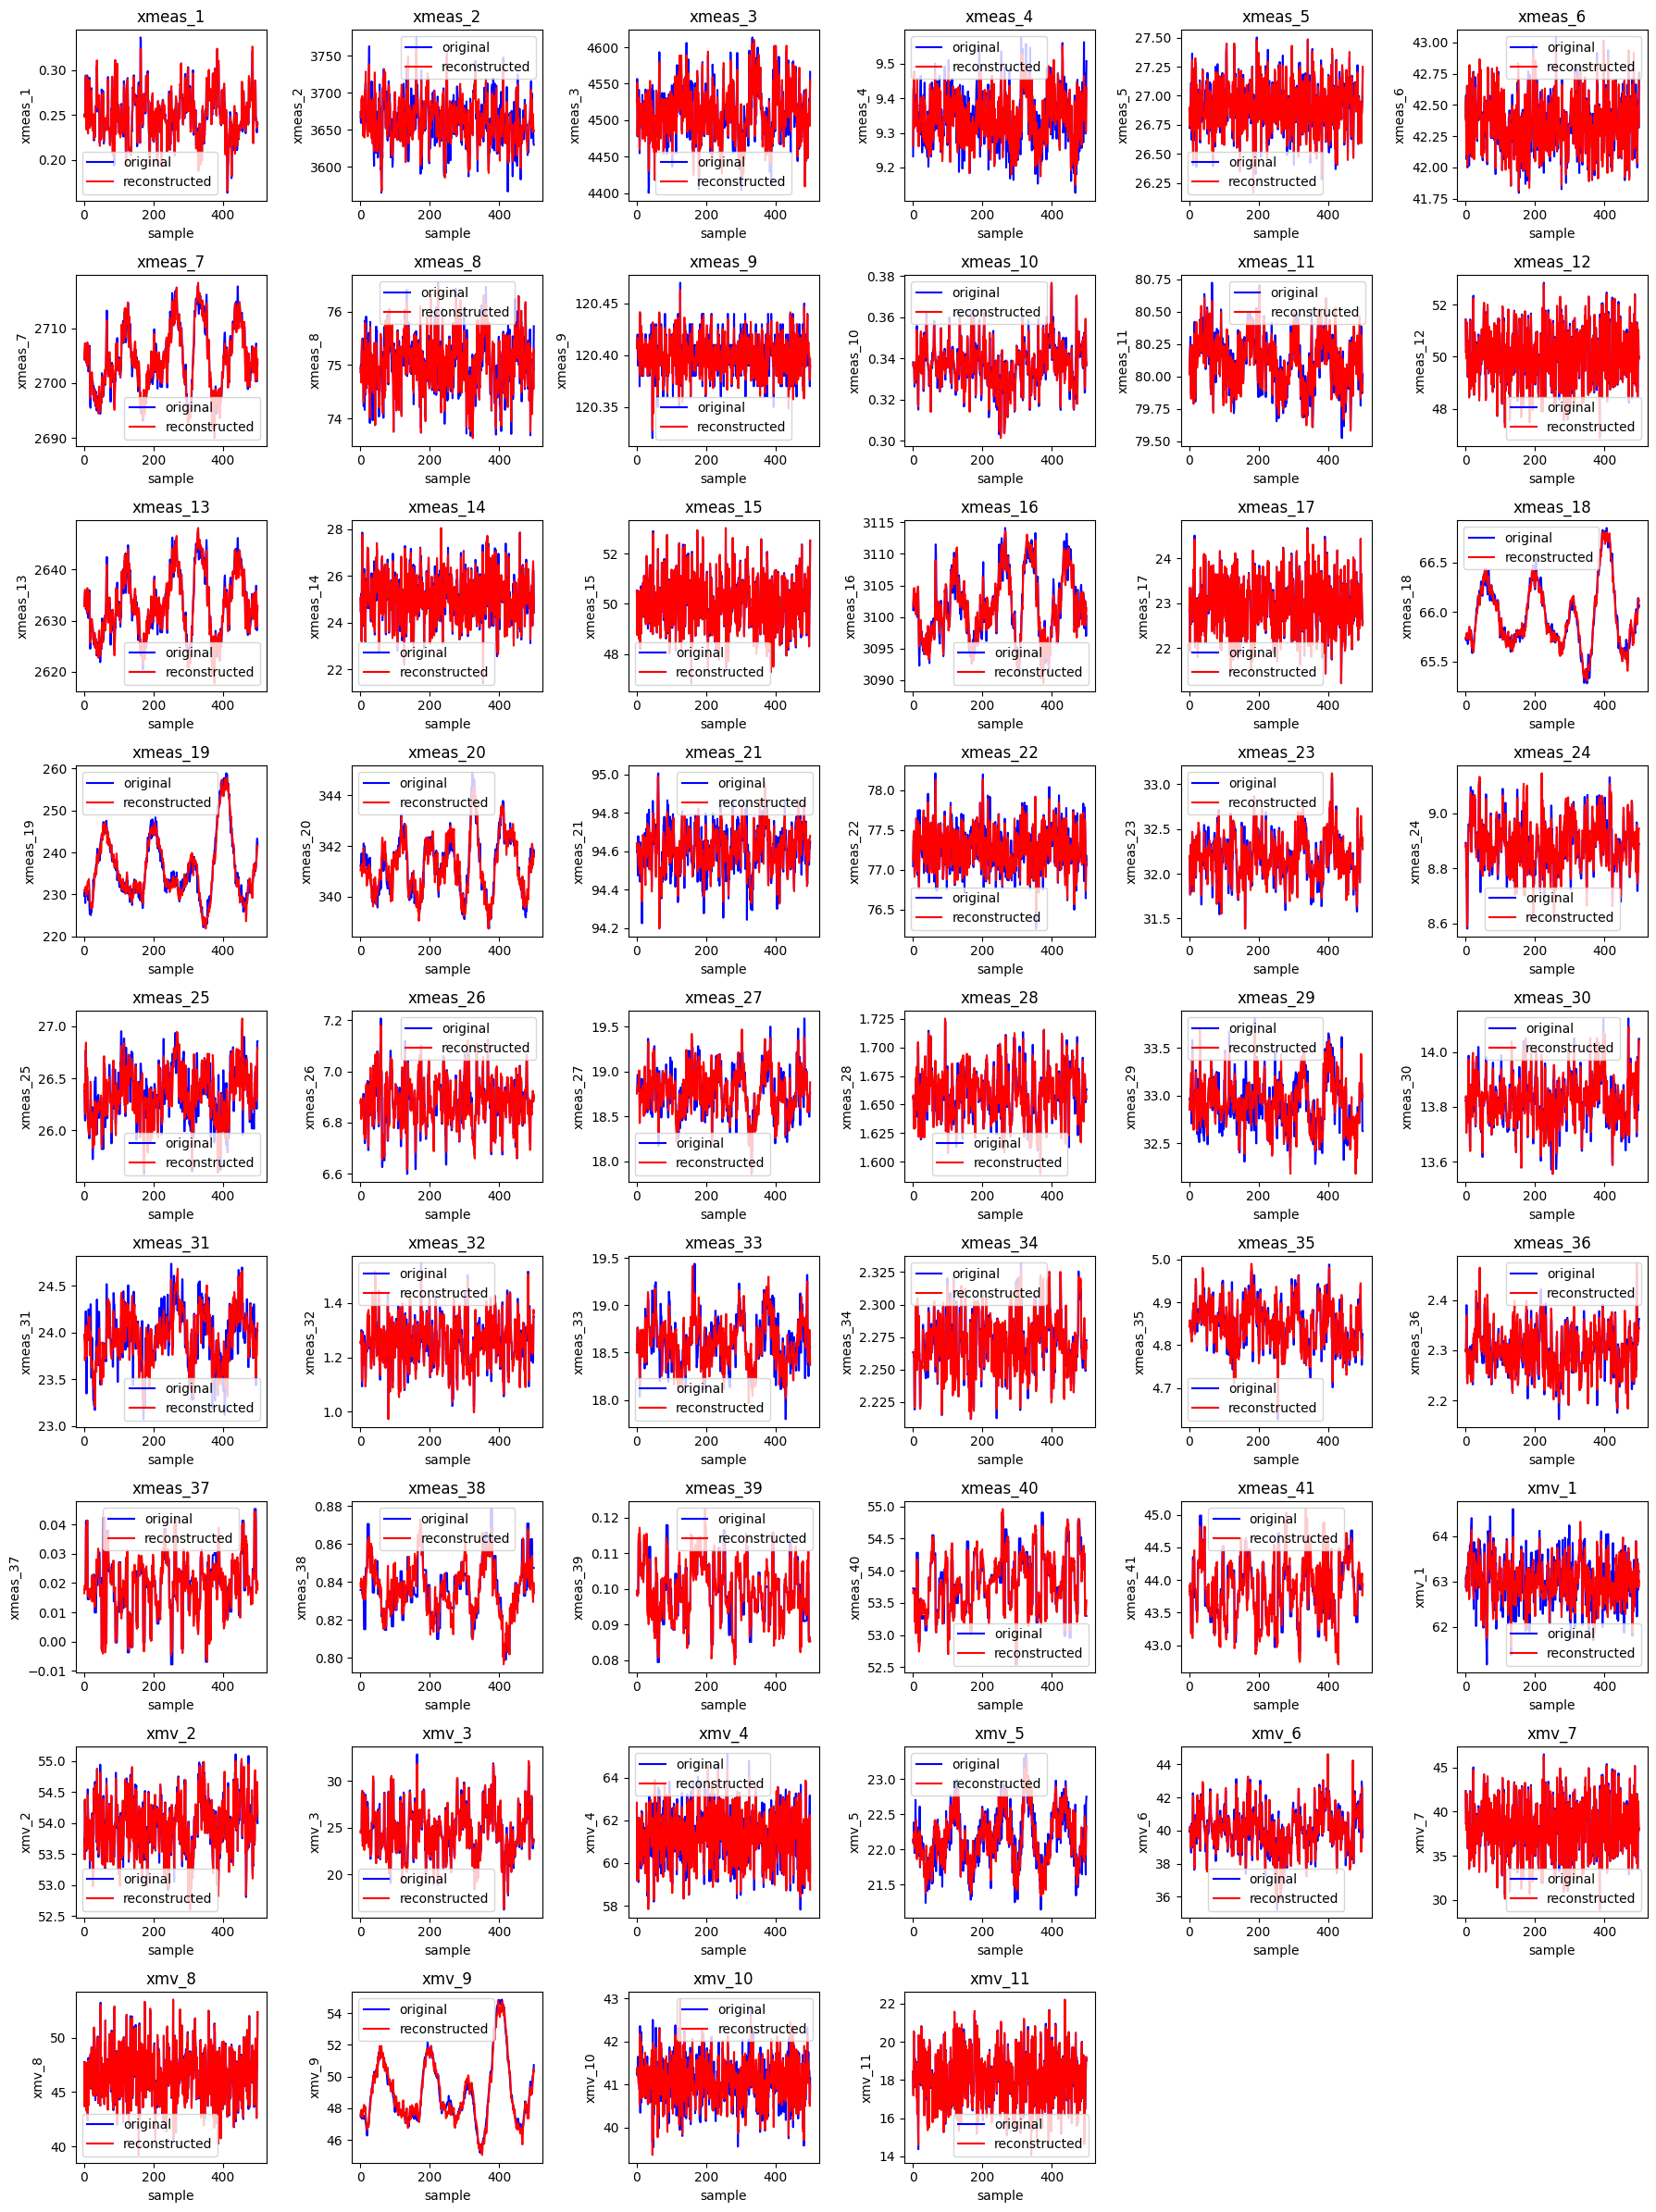

In [44]:
fig, axes = plt.subplots(nrows=9, ncols=6, figsize=(18, 24))

axes = axes.flatten()

for idx, col in enumerate(DF.columns[3:]):
    ax = axes[idx]
    ax.plot(DF['sample'], DF[col], color='b', label='original')
    ax.plot(DF['sample'], FreeFaulty_restored_plot[col], color='r', label='reconstructed')
    ax.set_title(col)
    ax.set_xlabel('sample')
    ax.set_ylabel(col)
    ax.legend()

for i in range(len(DF.columns[3:]), len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()

In [45]:
def get_anomaly_scores(original, reconstructed):
    loss = np.mean((original - reconstructed) ** 2, axis=1)
    #loss = pd.DataFrame(data=loss)#, index=df_original.index
    return loss

In [46]:
original=df_train_scaled
faulty_free_score=get_anomaly_scores(original,FreeFaulty_reconstructed)

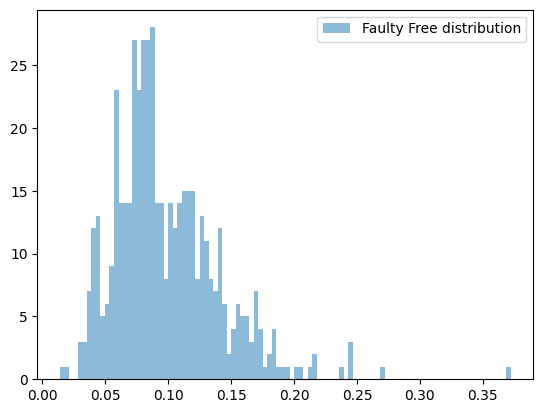

In [47]:
plt.hist(faulty_free_score,bins=100, alpha=0.5, label='Faulty Free distribution')
plt.legend()
plt.show()

__Faulty case__

In [48]:
df_faulty_scaled=scaler.transform(df_faulty_clean)
x_test_pca = pd.DataFrame(pca.transform(df_faulty_scaled))

In [49]:
data_restored = pca.inverse_transform(x_test_pca)
df_restored = pd.DataFrame(data_restored, index=x_test_pca.index)
df_restored.columns = columns
#df_restored.head()

In [50]:
inverse=scaler.inverse_transform(data_restored)
df_restored_plot = pd.DataFrame(inverse, index=x_test_pca.index)
df_restored_plot.columns = columns

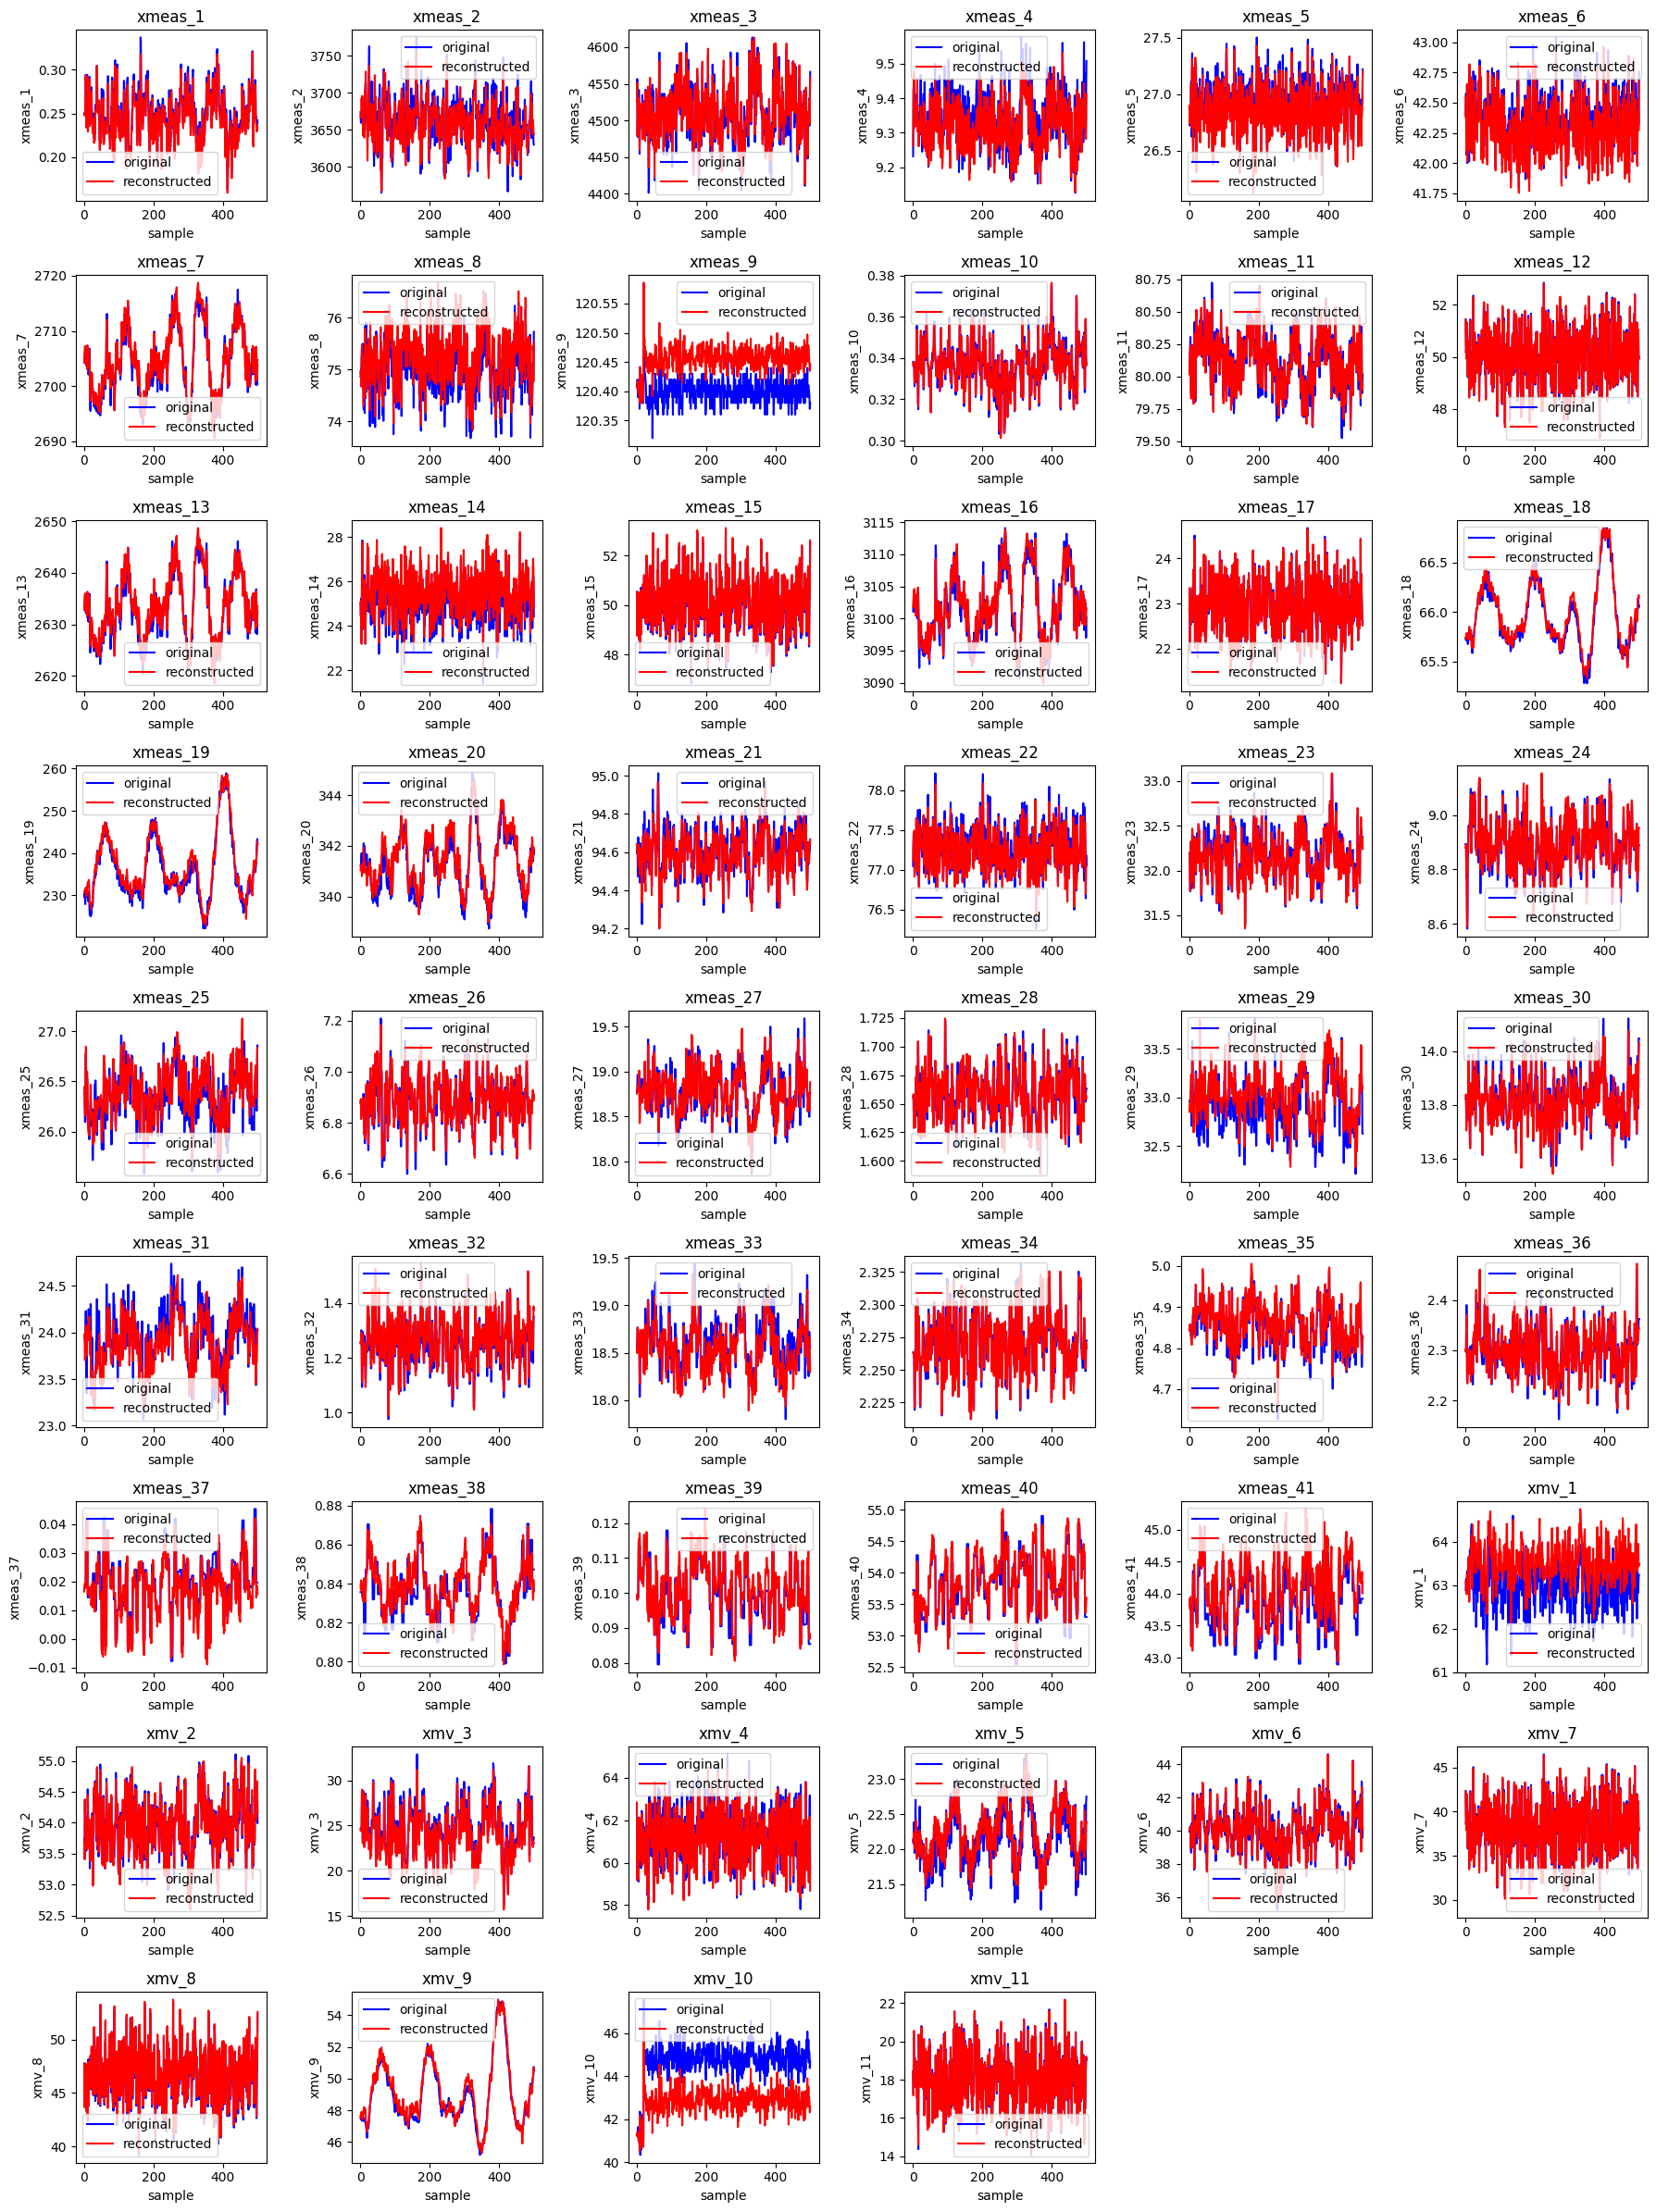

In [51]:
fig, axes = plt.subplots(nrows=9, ncols=6, figsize=(18, 24))

axes = axes.flatten()

for idx, col in enumerate(DF_faulty.columns[3:]):
    ax = axes[idx]
    ax.plot(DF_faulty['sample'], DF_faulty[col], color='b', label='original')
    ax.plot(DF_faulty['sample'], df_restored_plot[col], color='r', label='reconstructed')
    ax.set_title(col)
    ax.set_xlabel('sample')
    ax.set_ylabel(col)
    ax.legend()

for i in range(len(DF_faulty.columns[3:]), len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()

In [52]:
original=df_faulty_scaled
faulty_score=get_anomaly_scores(original,data_restored)

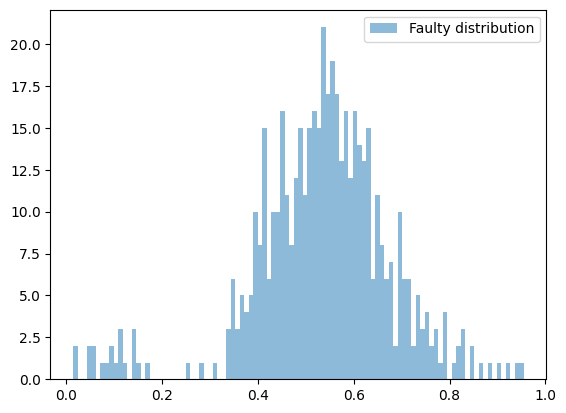

In [53]:
plt.hist(faulty_score,bins=100,alpha=0.5, label='Faulty distribution')
plt.legend()
plt.show()

__Defining failure threshold__

In [54]:
mu=np.mean(faulty_free_score)
std=np.std(faulty_free_score)
threshold=mu+3*std
threshold

0.22467313260643298

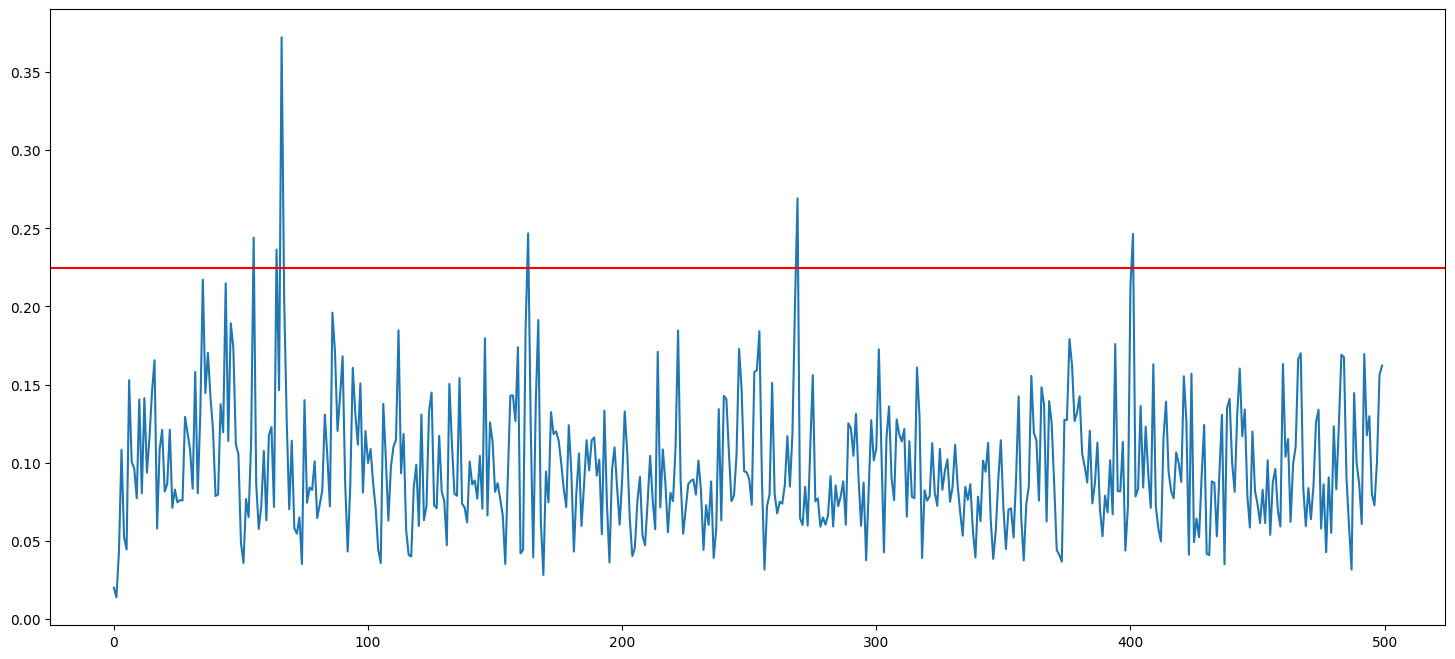

In [55]:
plt.figure(figsize=(18,8))
plt.plot(faulty_free_score,label='Faulty free score')
plt.axhline(y=threshold,c='r', label='Threshold')

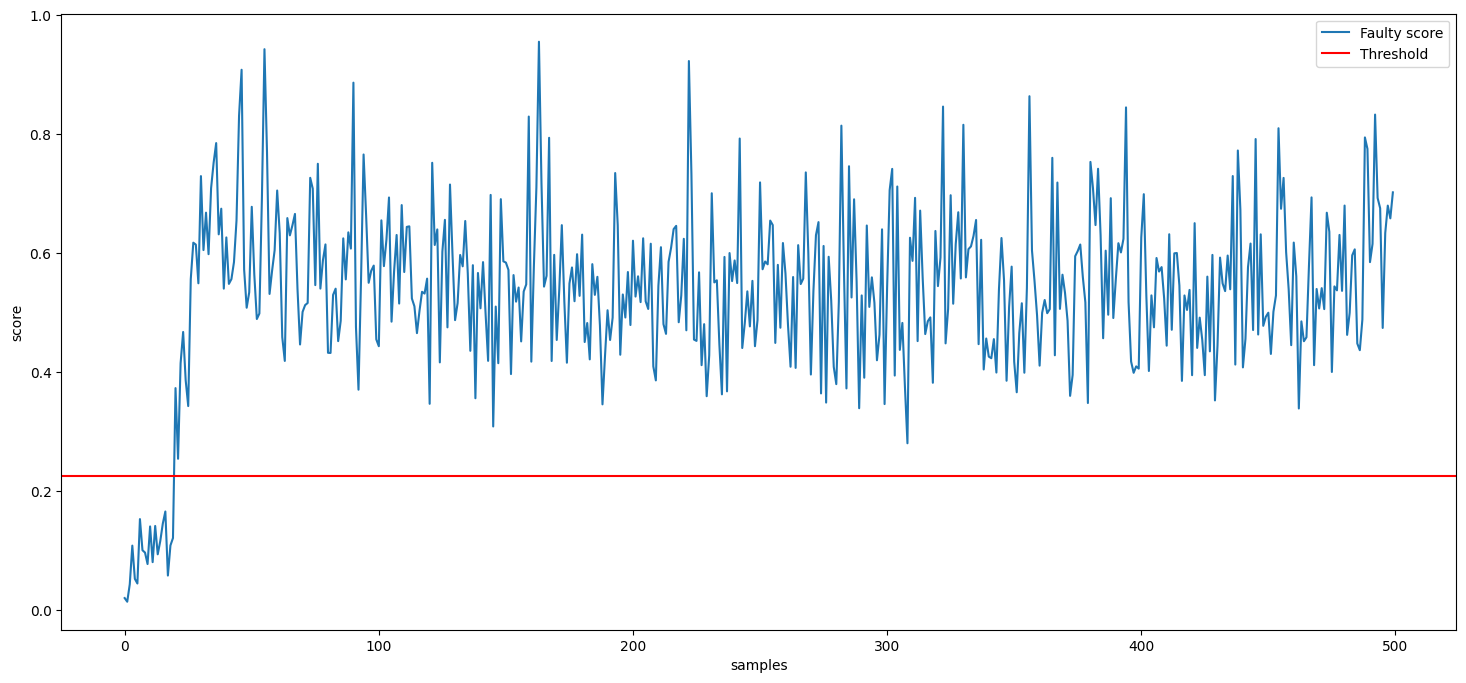

In [56]:
plt.figure(figsize=(18,8))
plt.plot(faulty_score,label='Faulty score')
plt.axhline(y=threshold,c='r', label='Threshold')
plt.xlabel('samples')
plt.ylabel('score')
plt.legend()
plt.show()

In [57]:
prova_threshold = np.percentile(faulty_free_score, 99) 
prova_threshold

0.23650032840201637